In [6]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader, read_and_prepare_data
from torch_geometric_temporal.signal import temporal_signal_split
import torch

In [7]:
torch.cuda.empty_cache() 

In [8]:
trafo_id = "T1330"

loader = SimpleGraphVoltDatasetLoader(trafo_id)
loader_data = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=4)

train_dataset, test_eval_dataset = temporal_signal_split(loader_data, train_ratio=0.7)
test_dataset, eval_dataset = temporal_signal_split(test_eval_dataset, train_ratio=0.5)


In [4]:
train_dataset[0]

Data(x=[113, 21, 12], edge_index=[2, 114], edge_attr=[114], y=[113, 4])

In [15]:
train_dataset[0]

Data(x=[113, 21, 12], edge_index=[2, 114], edge_attr=[114], y=[113, 4])

In [5]:
train_dataset[0].x.shape[1]
train_dataset[0].y.shape[1]

4

In [9]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm

In [10]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        out_channels = 32
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=out_channels, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [11]:
def train_test(model, device, train_dataset, test_dataset, optimizer, loss_fn, epochs):
    """
    Definition of the training loop.
    """
    epoch_losses_train = []
    epoch_losses_test = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0
        for snapshot in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot.to(device)
            optimizer.zero_grad()
            out = model(snapshot.x, snapshot.edge_index)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()
        epoch_losses_train.append(epoch_loss_train)
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for snapshot in tqdm(test_dataset, desc="Testing epoch {}".format(epoch)):
                snapshot.to(device)
                out = model(snapshot.x, snapshot.edge_index)
                loss = loss_fn()(out, snapshot.y)
                epoch_loss_test += loss.detach().cpu().numpy()
            epoch_losses_test.append(epoch_loss_test)
            print("Epoch: {}, Train Loss: {:.7f}, Test Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_test))
        
        
    return epoch_losses_train, epoch_losses_test
            
    
    

In [12]:
device = torch.device('cuda')
model = TemporalGNN(node_features=train_dataset[0].x.shape[1], periods=train_dataset[0].y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss
losses = train_test(model, device, train_dataset, test_dataset, optimizer, loss_fn, epochs=2)

Training epoch 0: 49045it [03:45, 217.61it/s]
Testing epoch 0: 10510it [00:27, 381.20it/s]


Epoch: 0, Train Loss: 1220.9180334, Test Loss: 7321.8180757


Training epoch 1: 49045it [03:45, 217.34it/s]
Testing epoch 1: 10510it [00:28, 373.39it/s]

Epoch: 1, Train Loss: 573.0778969, Test Loss: 6964.5486616


In [32]:
std = loader.mean_and_std["measurements"][1]["voltage"]

In [39]:
def eval(model, eval_dataset, device, loss_fn, std):
    with torch.no_grad():
        std = loader.mean_and_std["measurements"][1]["voltage"]
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        steps = 0
        for snapshot in tqdm(eval_dataset, desc="Evaluating"):
            steps += 1
            snapshot = eval_dataset[0].to(device)
            out = model(snapshot.x, snapshot.edge_index)
            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()
        loss_all *= std/steps
        loss_elementwise *= std/steps
        
    return loss_all, loss_elementwise

: 

In [17]:
#import sleep
import time

In [19]:
a = torch.randn(1000, 1000).to(device)

In [21]:
#check on which device is a tensor
a.device

device(type='cuda', index=0)

In [1]:
loss_train, loss_test = ([1194.0763882631436, 714.2401364590041, 725.4053290896118, 732.0262321201153, 633.8496168064885, 436.82765582599677, 332.78621608624235, 702.1066274656914, 680.6812678272836, 547.3687970221508, 557.6793491563294, 496.5474961954169, 368.69029581570067, 430.69174093636684, 404.8518018457107, 319.3614354818128, 331.4466990281362, 306.8085335609503, 287.5826617027633, 253.08790106675588, 333.58399638487026, 252.22530337586068, 271.39466513623483, 295.6837454563938, 279.4590763184242, 432.82811451051384, 415.032352702925, 271.29167147073895, 281.04732171981595, 274.5046267148573, 392.1390510494821, 406.2534522518981, 351.5974020441063, 369.9834475121461, 539.3651843662374, 488.53511515958235, 674.6448653545231, 1593.7771400166675, 634.3314090971835, 510.6811326709576, 547.6558932815678, 937.8391716778278, 1036.5518465717323, 628.6587420576252, 560.7739831702784, 419.1303832898848, 635.6583777721971, 364.28876812709495, 615.0327817709185, 521.0549582515378], [3927.43281796854, 3782.7006290066056, 7213.415033101104, 2362.879269486759, 2634.230386424344, 1662.7156716659665, 1896.6909063013736, 1685.0334544326179, 3985.1150153302588, 1122.9556974922307, 758.9877971936949, 425.8438631547615, 215.15151588385925, 439.51760928705335, 208.84630545927212, 145.44830755330622, 644.1860240283422, 491.55741419130936, 182.7890511956066, 198.23103187023662, 135.49589936295524, 187.81119603547268, 138.96795367239974, 294.6845012232661, 152.59143278049305, 194.65263554477133, 113.72101397905499, 85.17095784517005, 218.1455741082318, 182.2272459086962, 472.47368868486956, 119.09670330630615, 95.99453651555814, 261.2118905019015, 183.4913901737891, 383.01239934563637, 1199.8552622008137, 590.3776230020449, 388.6423648255877, 547.8931721383706, 409.81168330740184, 316.4386995313689, 696.0229505952448, 165.88542330544442, 223.67157765338197, 556.9328961628489, 214.77360255084932, 135.01676847413182, 472.1124603636563, 220.94689676584676])

In [4]:
min(loss_test)

85.17095784517005

In [ ]:
pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

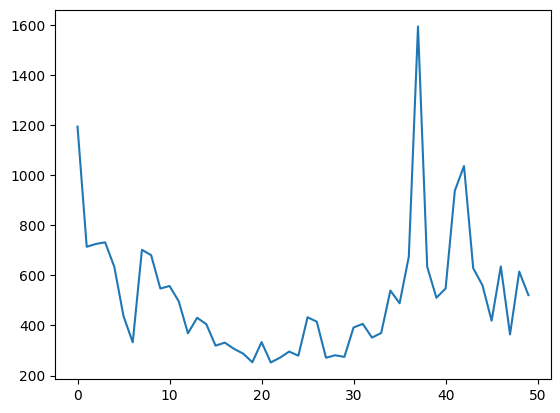

In [2]:
import matplotlib.pyplot as plt
plt.plot(loss_train)

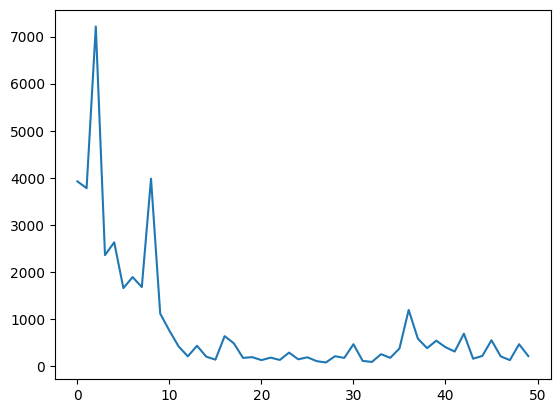

In [3]:
plt.plot(loss_test)